<a href="https://www.kaggle.com/code/w1ndness/data-analysis-07-lstm?scriptVersionId=109343800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrical-energy-load/test/1.csv
/kaggle/input/electrical-energy-load/test/3.csv
/kaggle/input/electrical-energy-load/test/.pdf
/kaggle/input/electrical-energy-load/test/2-1.csv
/kaggle/input/electrical-energy-load/test/2-2.csv
/kaggle/input/electrical-energy-load/train/1.csv
/kaggle/input/electrical-energy-load/train/3.csv
/kaggle/input/electrical-energy-load/train/2.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
!nvidia-smi

Fri Oct 28 00:05:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1

In [ ]:
!rm -f model*

In [ ]:
train_data = pd.read_csv('/kaggle/input/electrical-energy-load/train/1.csv')
test_data = pd.read_csv('/kaggle/input/electrical-energy-load/test/1.csv', encoding='gb2312')

In [ ]:
train_data.head()

In [ ]:
train_data.columns = ['Date', 'Power']
train_data.head()

In [ ]:
train_data.shape

In [ ]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
grouper = pd.Grouper(key='Date', freq='15min')
train_data = train_data.groupby(grouper).first()
train_data.head()

In [ ]:
train_data.shape

In [ ]:
train_data.isnull().sum()

In [ ]:
train_data['Power'] = train_data['Power'].interpolate()
train_data.isnull().sum()

In [ ]:
train_data.to_csv('15min_freq.csv')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(40, 24))
sns.lineplot(data=train_data[100:300], x='Date', y='Power', ax=ax[0][0])
sns.lineplot(data=train_data[:1000], x='Date', y='Power', ax=ax[0][1])
sns.lineplot(data=train_data[:10000], x='Date', y='Power', ax=ax[1][0])
sns.lineplot(data=train_data, x='Date', y='Power', ax=ax[1][1])

In [ ]:
def split_dataset(data, train_size=.8, valid_size=.1):
    data_size = len(data)
    X_train = data[:int(data_size * train_size)].copy()
    X_valid = data[int(data_size * train_size):int(data_size * train_size) + int(data_size * valid_size)].copy()
    X_test = data[int(data_size * train_size) + int(data_size * valid_size):].copy()
    return X_train, X_valid, X_test

In [ ]:
train_bin, valid_bin, test_bin = split_dataset(train_data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
valid_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

train_bin = train_scaler.fit_transform(train_bin)
valid_bin = valid_scaler.fit_transform(valid_bin)
test_bin = test_scaler.fit_transform(test_bin)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size].ravel())
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [ ]:
window_size, predict_size = 96, 1

X_train, y_train = preprocessing(train_bin, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_bin, window_size, predict_size)
X_test, y_test = preprocessing(test_bin, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

In [ ]:
USE_MULTI_GPU = False

if USE_MULTI_GPU and torch.cuda.device_count() > 1:
    MULTI_GPU = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    device_ids = [0, 1]
else:
    MULTI_GPU = False

num_gpus = 2 if MULTI_GPU else 1    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [ ]:
from torch import nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
#         self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                  nn.ReLU(),
#                                  nn.Linear(self.hidden_size // 2, self.output_size))
#         self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 2)
#         self.fc2 = nn.Linear(self.hidden_size // 2, self.hidden_size // 4)
#         self.fc3 = nn.Linear(self.hidden_size // 4, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
#         print(output.shape)
        o = output[:, -1, :]
#         pred = self.reg(o)
        pred = self.linear(o)
        return pred

In [ ]:
from tqdm import tqdm

def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss


In [ ]:
params = {'input_size': 1,
          'hidden_size': 64,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.1,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 50}

In [ ]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model.pth')

In [ ]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q1 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def mape(truths, preds):
    return np.mean(np.abs((truths - preds) / truths)) * 100

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for each in y:
            truths.append(each.cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for each in y_hat:
                preds.append(each.cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = test_scaler.inverse_transform(truths)
    preds = test_scaler.inverse_transform(preds)
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [ ]:
truths, preds = test(params, test_loader, 'model.pth')

In [ ]:
from scipy.interpolate import make_interp_spline

x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

# Question 2

In [ ]:
df = pd.read_csv('15min_freq.csv')
df.head()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Tick'] = df['Hour'] * 4 + df['Minute'] // 15
df.drop(columns=['Date'], inplace=True)
df.head()

In [ ]:
groups = df.groupby(['Year', 'Month', 'Day'], as_index=False)
columns = ['Power', 'Year', 'Month', 'Day', 'Hour', 'Minute']
data_daily_max = pd.DataFrame(columns=columns)
data_daily_min = pd.DataFrame(columns=columns)
for group in groups:
    _, meta = group
    max_row = meta[meta['Power'] == meta['Power'].max()]
    min_row = meta[meta['Power'] == meta['Power'].min()]
    data_daily_max = pd.concat([data_daily_max, max_row], ignore_index=True)
    data_daily_min = pd.concat([data_daily_min, min_row], ignore_index=True)

In [ ]:
data_daily_max.head()

In [ ]:
data_daily_min.head()

In [ ]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Power'], c='g', label='Max')
plt.plot(x, data_daily_min['Power'], c='b', label='Min')
plt.legend()
plt.title('Daily Power Max & Min')

In [ ]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Tick'], c='g', label='Max')
plt.plot(x, data_daily_min['Tick'], c='b', label='Min')
plt.legend()
plt.title('Daily Max and Min Time (As Tick)')

In [ ]:
data_daily_max['Date'] = pd.to_datetime(data_daily_max[['Year', 'Month', 'Day']])
data_daily_min['Date'] = pd.to_datetime(data_daily_min[['Year', 'Month', 'Day']])

In [ ]:
weather_data = pd.read_csv('../input/electrical-energy-load/train/3.csv')
weather_data.head()

In [ ]:
weather_data.info()

In [ ]:
weather_data.columns = ['Date', 'Weather', 'HighTemp', 'LowTemp', 'DayWind', 'NightWind']
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('年', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('月', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('日', '-'))
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.head()

In [ ]:
weather_data['HighTemp'] = weather_data['HighTemp'].apply(lambda x: int(x[:-1]))
weather_data['LowTemp'] = weather_data['LowTemp'].apply(lambda x: int(x[:-1]))
weather_data['HighTemp'] = weather_data['HighTemp'].astype('int32')
weather_data['LowTemp'] = weather_data['LowTemp'].astype('int32')
weather_data.head()

In [ ]:
weather_data['Weather1'] = weather_data['Weather'].apply(lambda x: x.split('/')[0])
weather_data['Weather2'] = weather_data['Weather'].apply(lambda x: x.split('/')[1])
weather_data.drop(columns=['Weather'], inplace=True)
weather_data['Weather1'].value_counts(), weather_data['Weather2'].value_counts()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

weather_encoder = OneHotEncoder(handle_unknown='ignore')
weather_encoder.fit(weather_data[['Weather1', 'Weather2']].values)
mat = weather_encoder.transform(weather_data[['Weather1', 'Weather2']].values).toarray()
feature_labels = np.array(weather_encoder.categories_).ravel()

columns = []
for col in ['Weather1', 'Weather2']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))
        
onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

In [ ]:
wind_encoder = OneHotEncoder(handle_unknown='ignore')
wind_encoder.fit(weather_data[['DayWind', 'NightWind']].values)
mat = wind_encoder.transform(weather_data[['DayWind', 'NightWind']].values).toarray()
feature_labels = np.array(wind_encoder.categories_).ravel()

columns = []
for col in ['DayWind', 'NightWind']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))

onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

In [ ]:
weather_data.shape

In [ ]:
weather_data.drop(columns=['DayWind', 'NightWind', 'Weather1', 'Weather2'], inplace=True)
weather_data = weather_data.drop_duplicates(subset=['Date']).reset_index()
weather_data.shape

In [ ]:
daily_max_data = pd.merge(data_daily_max, weather_data, on='Date')
daily_min_data = pd.merge(data_daily_min, weather_data, on='Date')

In [ ]:
daily_max_data.index = daily_max_data['Date']
daily_min_data.index = daily_min_data['Date']
daily_max_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
daily_min_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [ ]:
daily_max_data.head()

In [ ]:
daily_max_data.info()

In [ ]:
# from sklearn.feature_selection import VarianceThreshold

# daily_max_data = daily_max_data.values
# daily_min_data = daily_min_data.values

# max_selector = VarianceThreshold(threshold=0.16)
# daily_max_data = np.concatenate([daily_max_data[:, :2], max_selector.fit_transform(daily_max_data[:, 2:])], axis=1)

# min_selector = VarianceThreshold(threshold=0.16)
# daily_min_data = np.concatenate([daily_min_data[:, :2], min_selector.fit_transform(daily_min_data[:, 2:])], axis=1)

In [ ]:
daily_max_data

In [ ]:
from scipy.signal import savgol_filter as SGFilt

train_bin_max, valid_bin_max, test_bin_max = split_dataset(daily_max_data, .7, .1)
train_bin_min, valid_bin_min, test_bin_min = split_dataset(daily_min_data, .7, .1)

w, p = 7, 3
train_bin_max['Power'] = SGFilt(train_bin_max['Power'], w, p)
train_bin_max['Tick'] = SGFilt(train_bin_max['Tick'], w, p)
train_bin_min['Power'] = SGFilt(train_bin_min['Power'], w, p)
train_bin_min['Tick'] = SGFilt(train_bin_min['Tick'], w, p)

In [ ]:
test_max_power_range = [test_bin_max['Power'].min(), test_bin_max['Power'].max()]
test_max_tick_range = [test_bin_max['Tick'].min(), test_bin_max['Tick'].max()]

test_min_power_range = [test_bin_min['Power'].min(), test_bin_min['Power'].max()]
test_min_tick_range = [test_bin_min['Tick'].min(), test_bin_min['Tick'].max()]

In [ ]:
def scaling(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [ ]:
train_max_scaler, train_max = scaling(train_bin_max)
train_min_scaler, train_min = scaling(train_bin_min)
valid_max_scaler, valid_max = scaling(valid_bin_max)
valid_min_scaler, valid_min = scaling(valid_bin_min)
test_max_scaler, test_max = scaling(test_bin_max)
test_min_scaler, test_min = scaling(test_bin_min)

Now daily max data on: train_max, valid_max, test_max

Now daily min data on: train_min, valid_min, test_min


## 2.1 For Daily Max

### 2.1.1 multi-output LSTM Regression Trail

In [ ]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [ ]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

In [ ]:
X_train.shape

In [ ]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [ ]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

In [ ]:
class LSTM_multi(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
#         self.reg_pred = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
#         self.reg_time = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
        self.linear_pred = nn.Linear(self.hidden_size, self.output_size)
        self.linear_time = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
        o = output[:, -1, :]
        pred, time = self.linear_pred(o), self.linear_time(o)
#         pred, time = self.reg_pred(o), self.reg_time(o)
        preds = torch.stack([pred, time], dim=0)
        return preds

In [ ]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [ ]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [ ]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max.pth')

In [ ]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [ ]:
truths, preds, scores = test(params, test_loader, 'model_max.pth')

In [ ]:
scores

In [ ]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

In [ ]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

### 2.1.2 single-output LSTM and train twice Trail

#### 2.1.2.1 Train Model for Power

In [ ]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :1].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [ ]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [ ]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [ ]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 128,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [ ]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_1.pth')

In [ ]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    preds = preds * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [ ]:
truths, preds = test(params, test_loader, 'model_max_1.pth')

In [ ]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

#### 2.1.2.2 Train Model for Tick

In [ ]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, 1:2].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [ ]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [ ]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 32,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [ ]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_2.pth')

In [ ]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    preds = preds * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [ ]:
truths, preds = test(params, test_loader, 'model_max_2.pth')

In [ ]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

## 2.2 For Daily Min

In [ ]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [ ]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_min, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_min, window_size, predict_size)
X_test, y_test = preprocessing(test_min, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [ ]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

In [ ]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 50, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [ ]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [ ]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_min.pth')

In [ ]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_min_power_range[1] - test_min_power_range[0]) + test_min_power_range[0]
        vals[1] = vals[1] * (test_min_tick_range[1] - test_min_tick_range[0]) + test_min_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores


In [ ]:
truths, preds, scores = test(params, test_loader, 'model_min.pth')

In [ ]:
scores

In [ ]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

In [ ]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

# Q3

In [78]:
cat_data = pd.read_csv('../input/electrical-energy-load/train/2.csv')
cat_data.head()

,行业类型,数据时间,有功功率最大值（kw）,有功功率最小值（kw）
0,大工业用电,2019-01-01,117888.3300,51526.5690
1,大工业用电,2019-01-02,126843.7914,63638.4294
2,大工业用电,2019-01-03,130286.1294,102048.2754
3,大工业用电,2019-01-04,133018.6344,104466.0762
4,大工业用电,2019-01-05,133504.4784,99507.3528


In [79]:
cat_data.columns = ['Category', 'Date', 'MaxPower', 'MinPower']
cat_data['Date'] = pd.to_datetime(cat_data['Date'])
cat_data['Category'].value_counts()

大工业用电    973
普通工业     973
商业       973
非普工业     691
Name: Category, dtype: int64

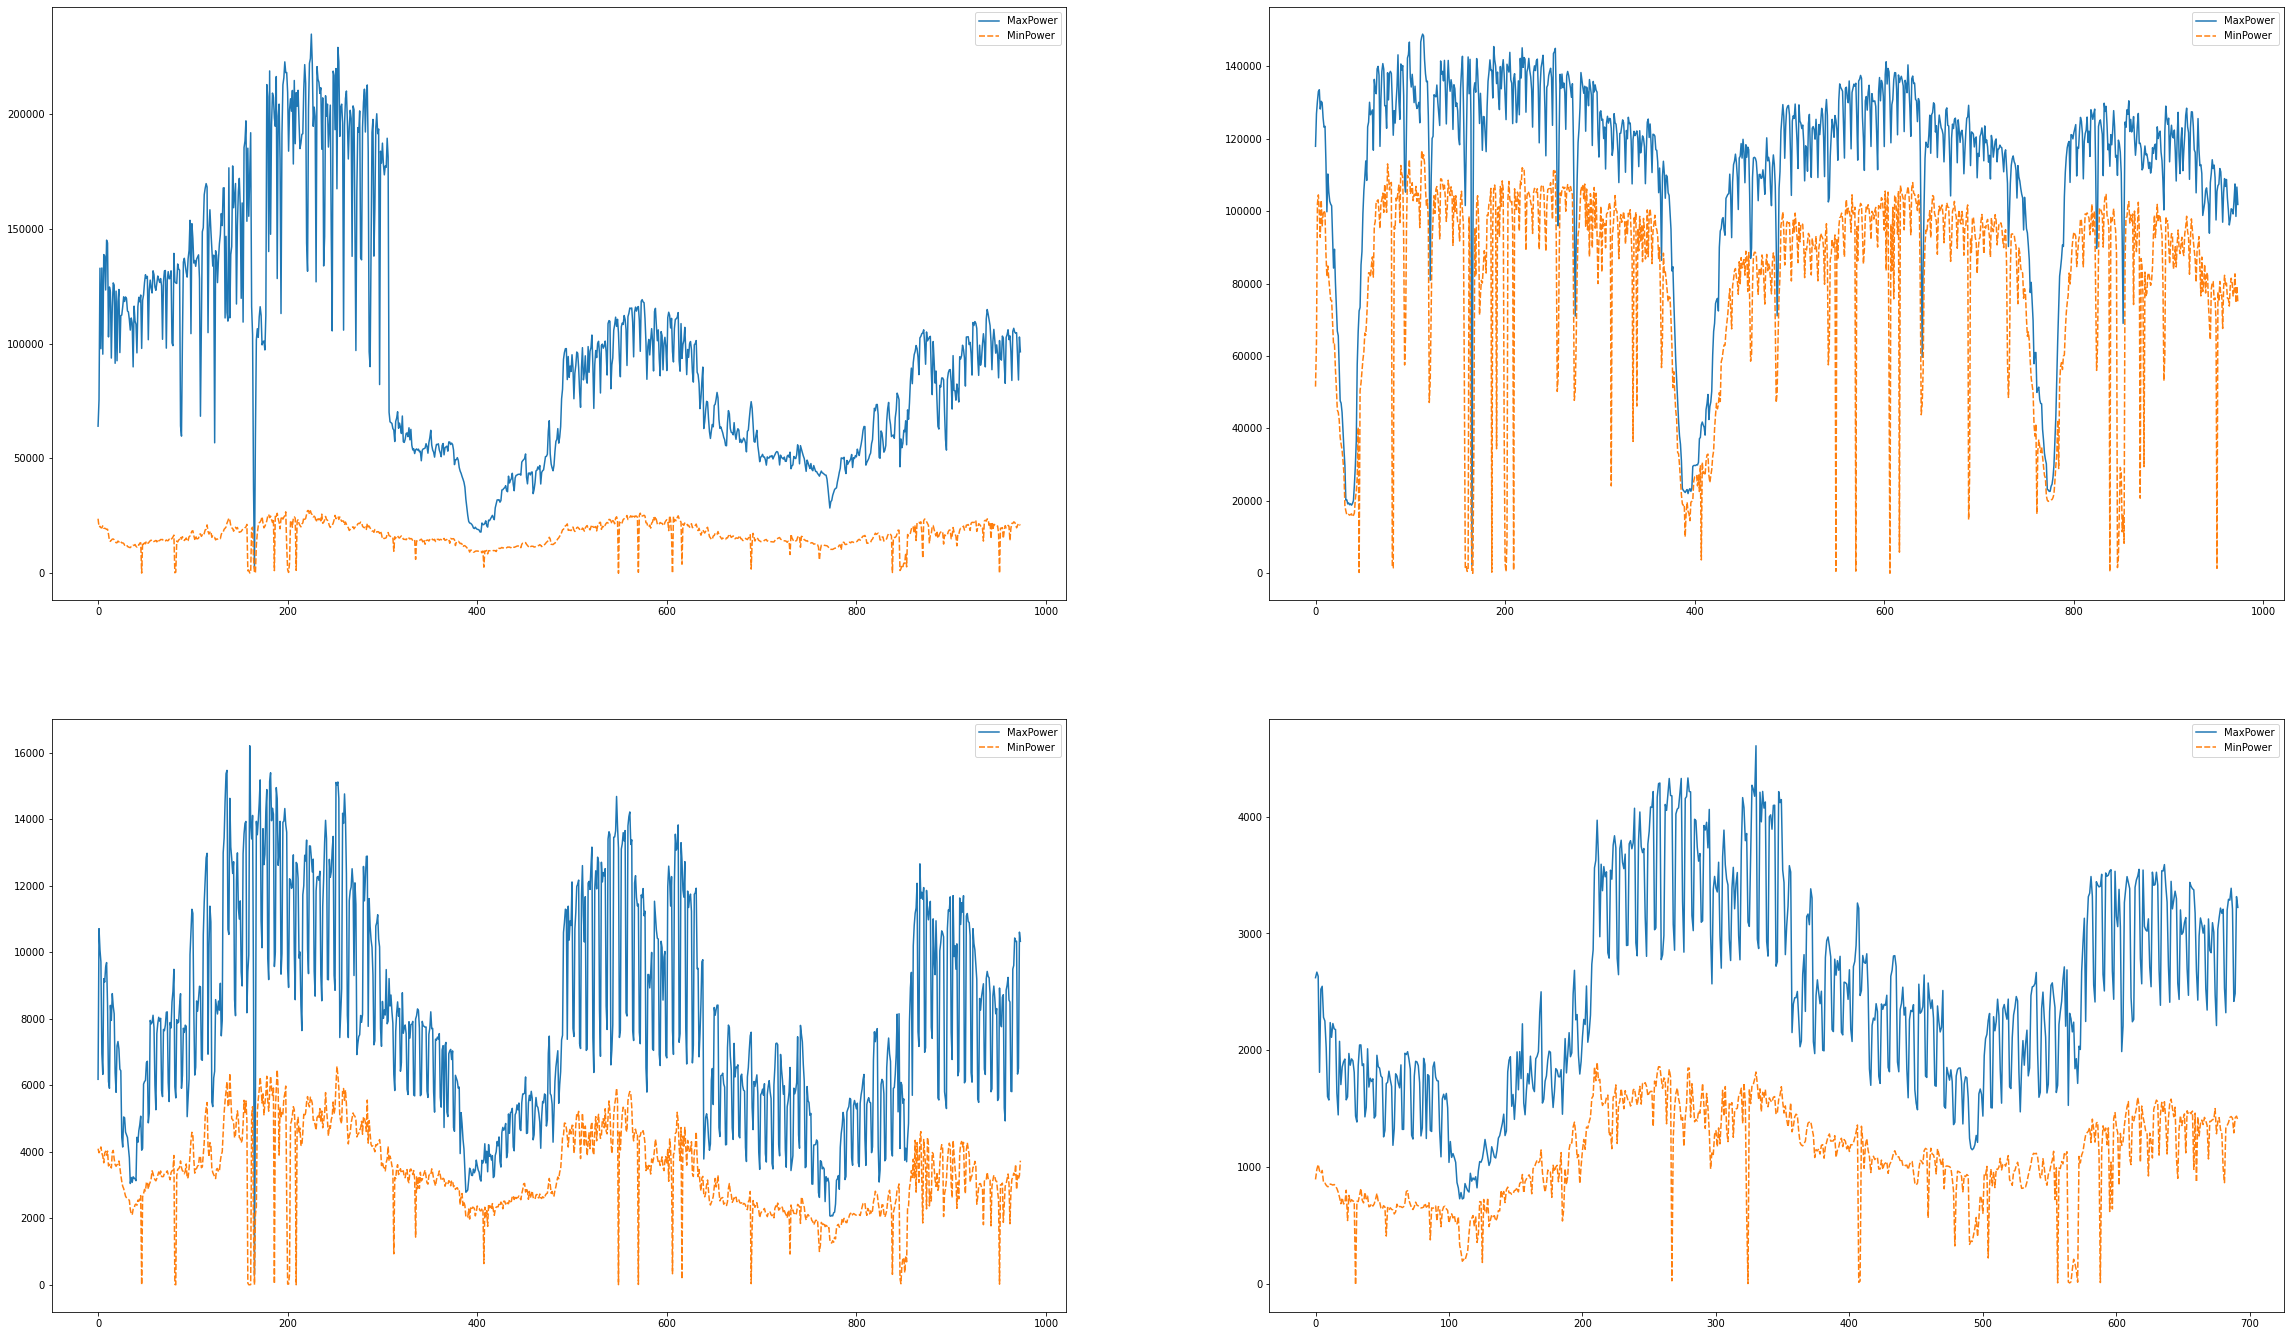

In [80]:
groups = cat_data.groupby(['Category'], as_index=False)
fig, axes = plt.subplots(2, 2, figsize=(40, 24))
all_data = pd.DataFrame(columns=['Category', 'Date', 'MaxPower', 'MinPower'])
for i, group in enumerate(groups):
    x, y = i // 2, i % 2
    category, df = group
    grouper = pd.Grouper(key='Date', freq='D')
    res = df.groupby(grouper).first().reset_index()
    res = res[['Category', 'Date', 'MaxPower', 'MinPower']]
    all_data = pd.concat([all_data, res], ignore_index=True)
    res['MaxPower'] = res['MaxPower'].interpolate()
    res['MinPower'] = res['MinPower'].interpolate()
    res.to_csv(f'{category}.csv', index=False)
    sns.lineplot(data=res[['MaxPower', 'MinPower']], ax=axes[x][y])
all_data.to_csv('处理后数据.csv', index=False)

## Q3.1

In [81]:
all_data.head()

,Category,Date,MaxPower,MinPower
0,商业,2019-01-01,64027.8582,23758.7970
1,商业,2019-01-02,75467.2143,20231.6265
2,商业,2019-01-03,132776.9442,20443.6182
3,商业,2019-01-04,97731.1308,19858.1592
4,商业,2019-01-05,132883.1868,19766.6994


In [82]:
def MK(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    # 正序列计算---------------------------------
    # 定义累计量序列Sk，初始值=0
    Sk             = [0]
    # 定义统计量UFk，初始值 =0
    UFk            = [0]
    # 定义Sk序列元素s，初始值 =0
    s              =  0
    Exp_value      = [0]
    Var_value      = [0]
    # i从1开始，因为根据统计量UFk公式，i=0时，Sk(0)、E(0)、Var(0)均为0
    # 此时UFk无意义，因此公式中，令UFk(0)=0
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
    # ------------------------------正序列计算
    # 逆序列计算---------------------------------
    # 定义逆序累计量序列Sk2，长度与inputdata一致，初始值=0
    Sk2             = [0]
    # 定义逆序统计量UBk，长度与inputdata一致，初始值=0
    UBk             = [0]
    UBk2            = [0]
    # s归0
    s2              =  0
    Exp_value2      = [0]
    Var_value2      = [0]
    # 按时间序列逆转样本y
    inputdataT = list(reversed(inputdata))
    # i从2开始，因为根据统计量UBk公式，i=1时，Sk2(1)、E(1)、Var(1)均为0
    # 此时UBk无意义，因此公式中，令UBk(1)=0
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    # 由于对逆序序列的累计量Sk2的构建中，依然用的是累加法，即后者大于前者时s加1，
    # 则s的大小表征了一种上升的趋势的大小，而序列逆序以后，应当表现出与原序列相反
    # 的趋势表现，因此，用累加法统计Sk2序列，统计量公式(S(i)-E(i))/sqrt(Var(i))
    #也不应改变，但统计量UBk应取相反数以表征正确的逆序序列的趋势
    #  UBk(i)=0-(Sk2(i)-E)/sqrt(Var)
    # ------------------------------逆序列计算
    # 此时上一步的到UBk表现的是逆序列在逆序时间上的趋势统计量
    # 与UFk做图寻找突变点时，2条曲线应具有同样的时间轴，因此
    # 再按时间序列逆转结果统计量UBk，得到时间正序的UBkT，
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    # 找出交叉点
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
    # 做突变检测图时，使用UFk和UBkT
    plt.figure(figsize=(20, 12))
    plt.plot(range(1,n+1) ,UFk  ,label='UFk') # UFk
    plt.plot(range(1,n+1) ,UBkT ,label='UBk') # UBk
    plt.ylabel('UFk-UBk Graph')
    x_lim = plt.xlim()
    plt.plot(x_lim,[-1.96,-1.96],'m--',color='r')
    plt.plot(x_lim,[  0  ,  0  ],'m--')
    plt.plot(x_lim,[+1.96,+1.96],'m--',color='r')
    plt.legend(loc=2) # 图例
    plt.title('UFk-UBk')
    plt.show()
    return K

==================商业====================


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.


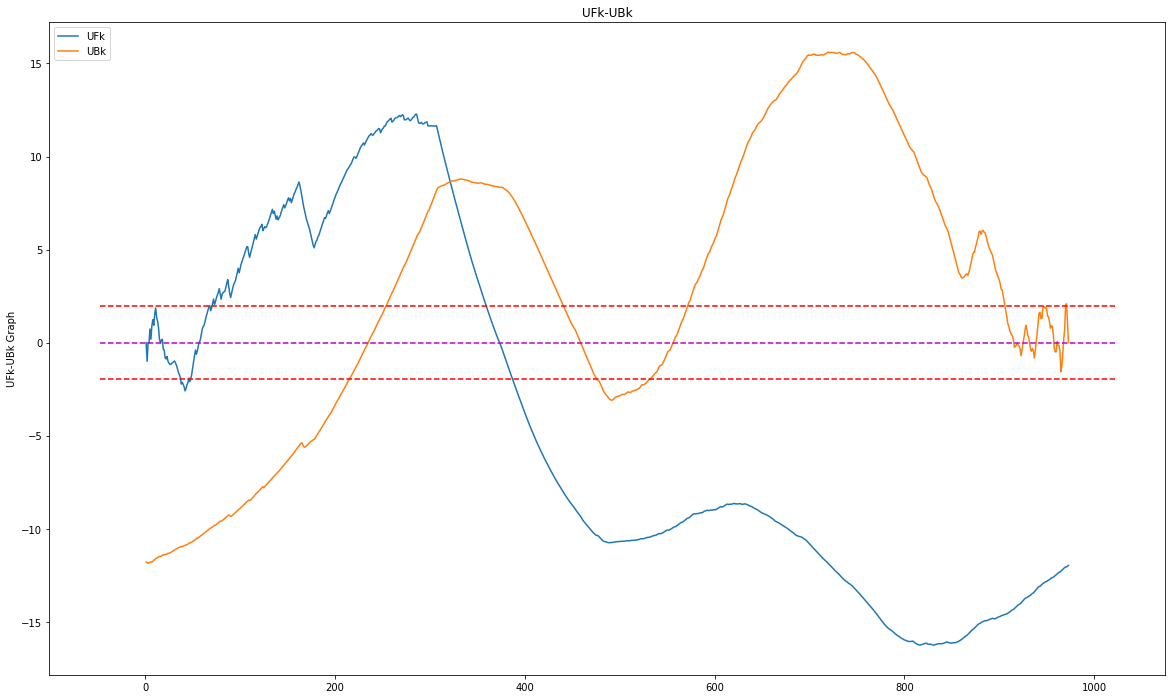

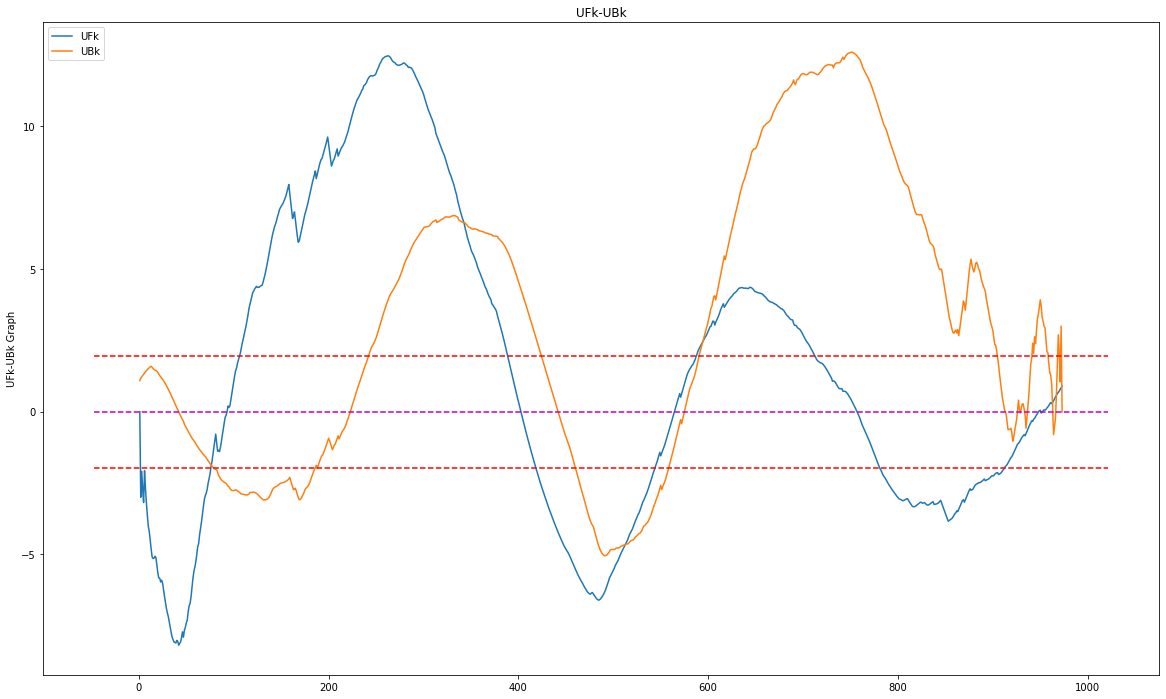

Category 商业 max: [321]
Category 商业 min: [76, 342, 512, 594, 962, 966, 972]


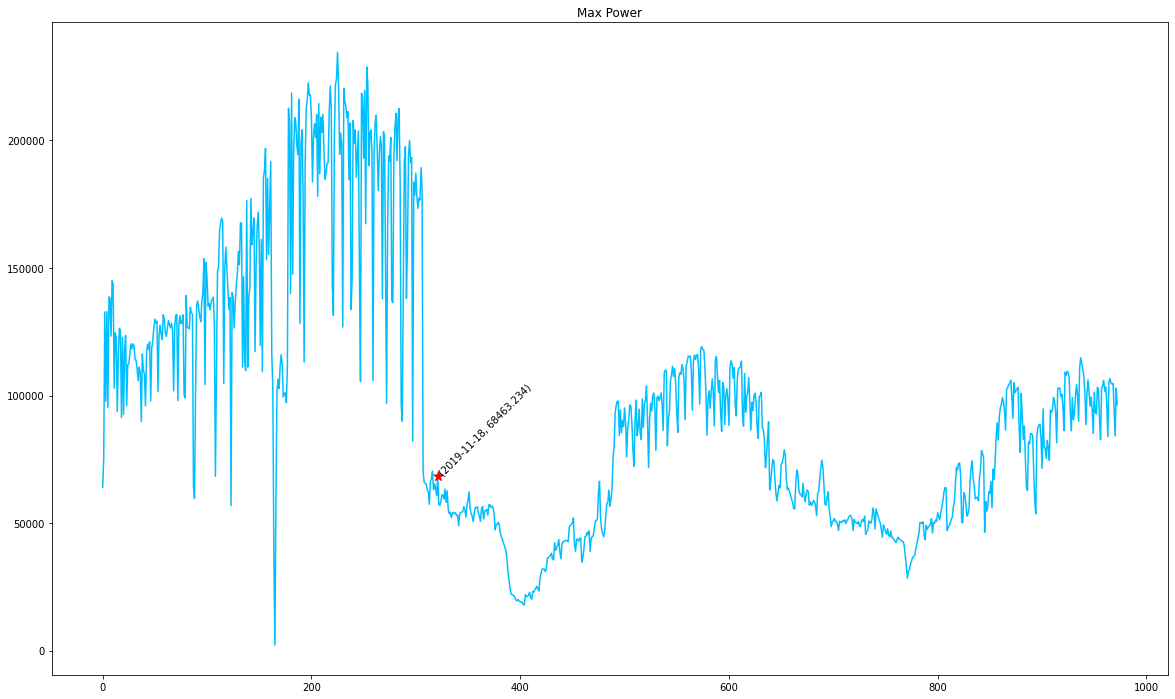

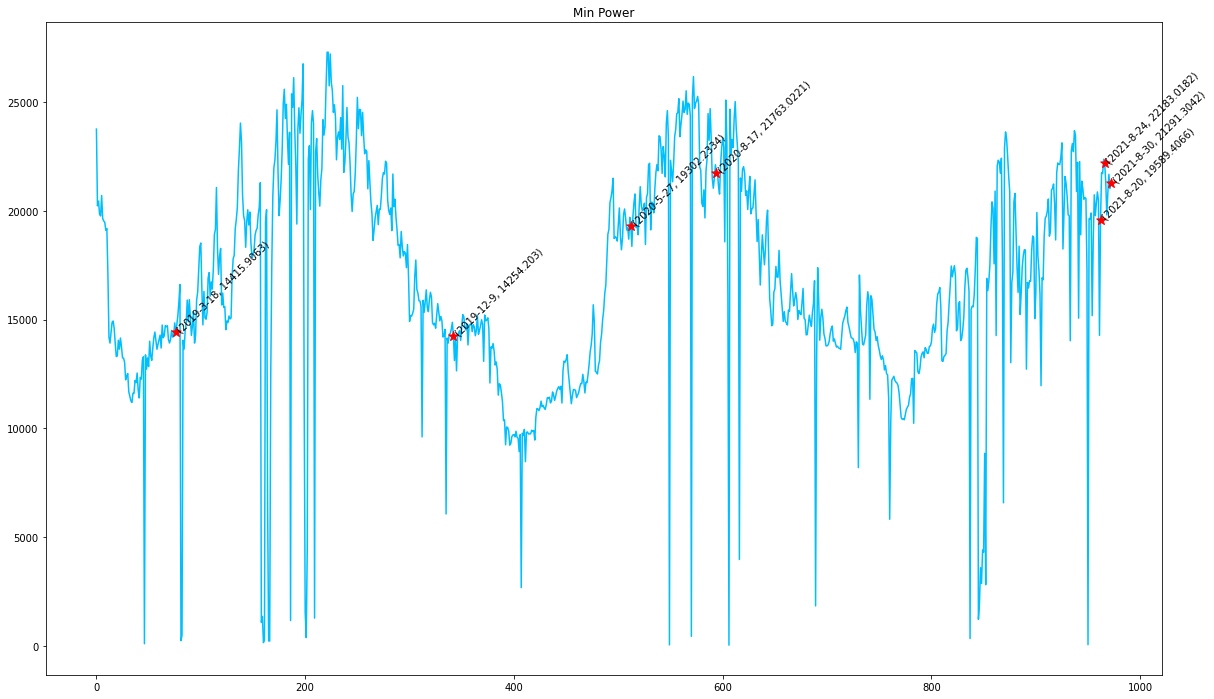

==================大工业用电====================


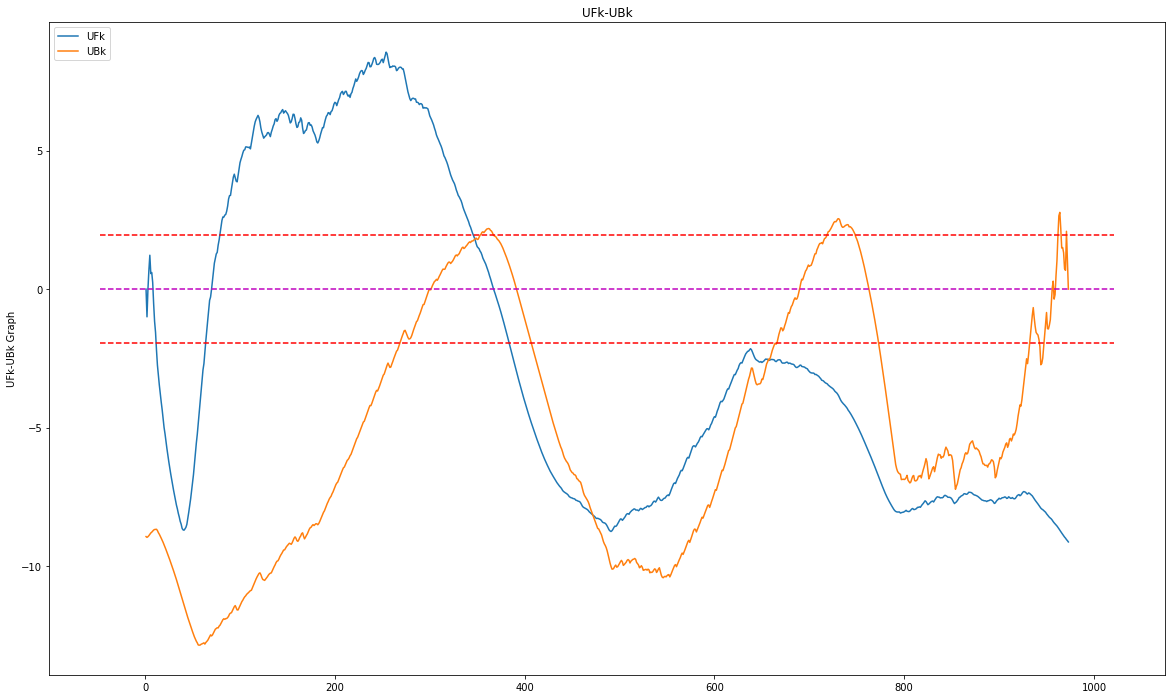

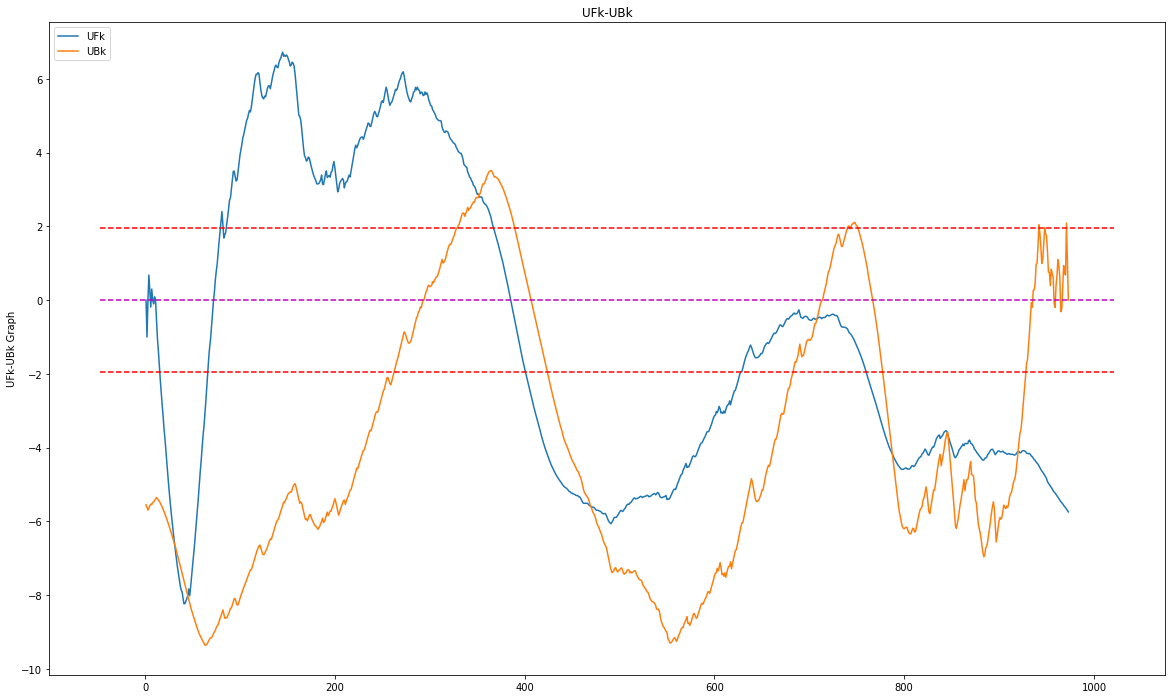

Category 大工业用电 max: [347, 471, 656]
Category 大工业用电 min: [31, 44, 351, 469, 708, 787, 845, 846, 919]


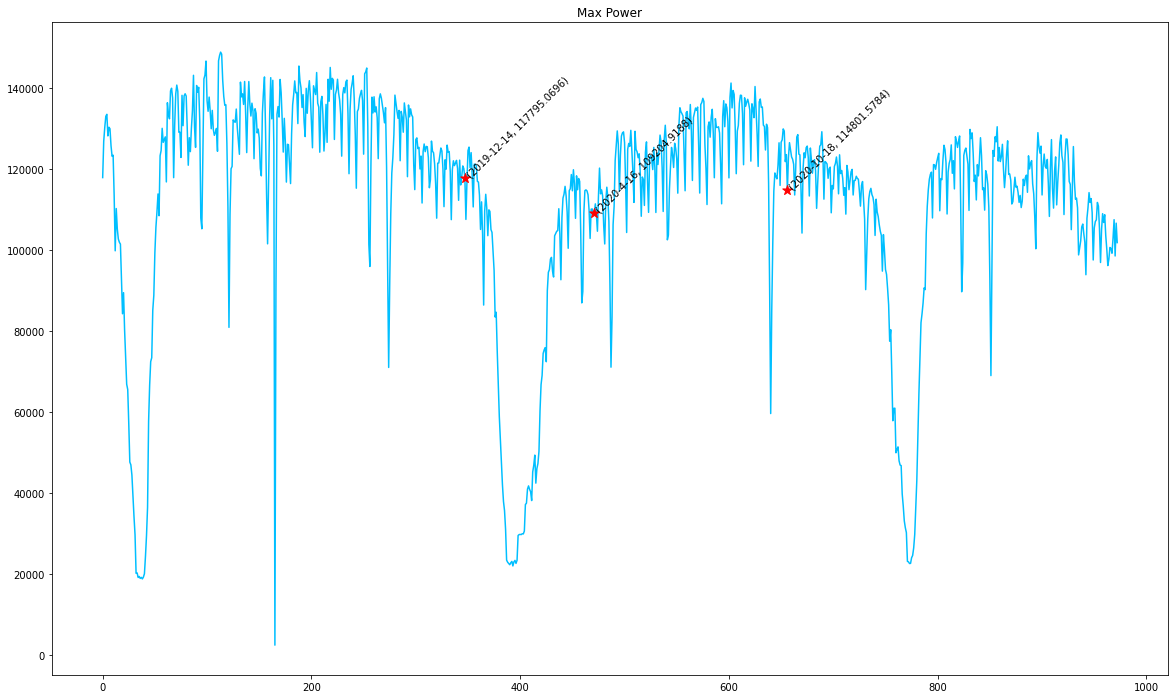

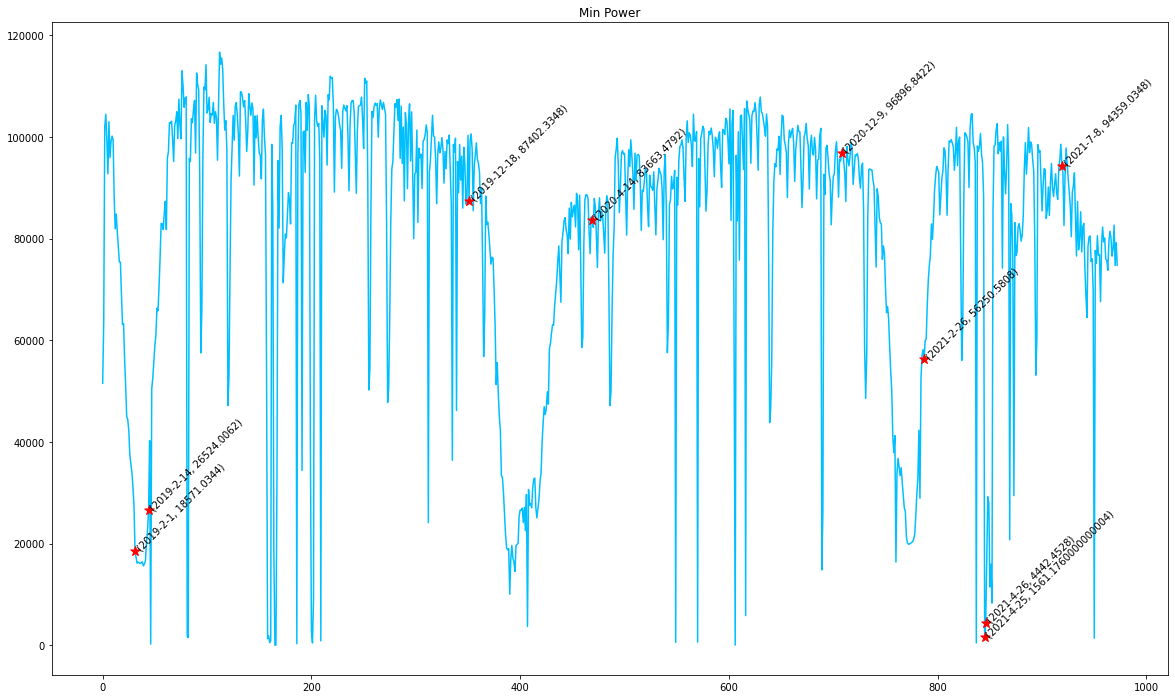

==================普通工业====================


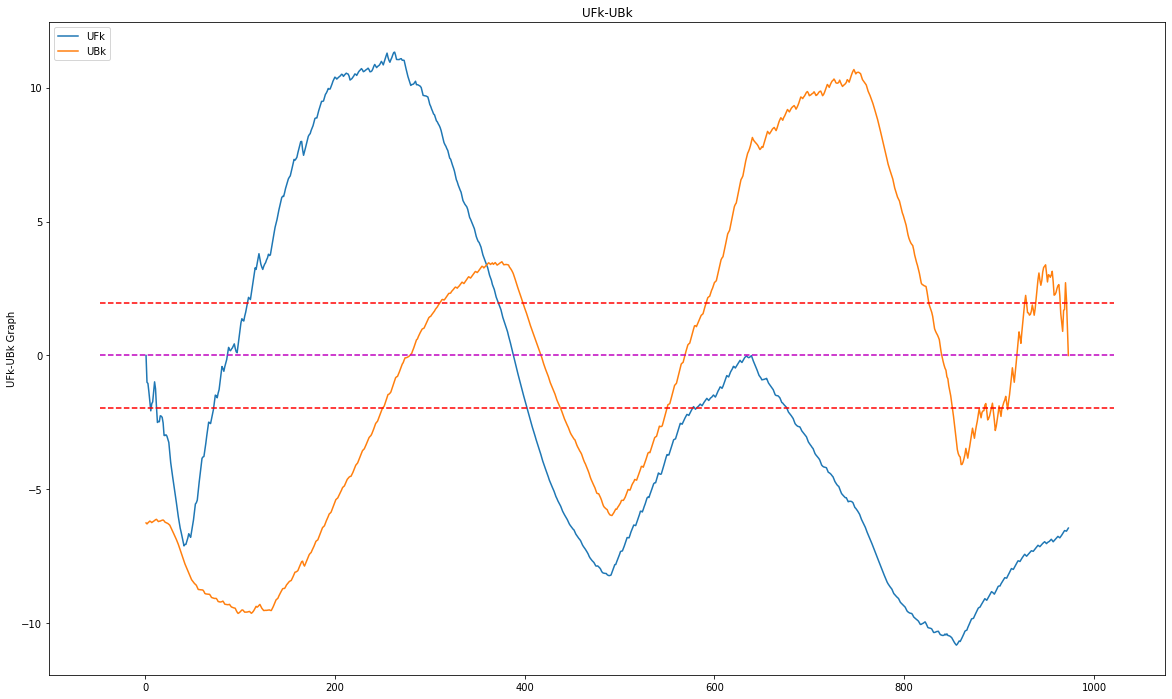

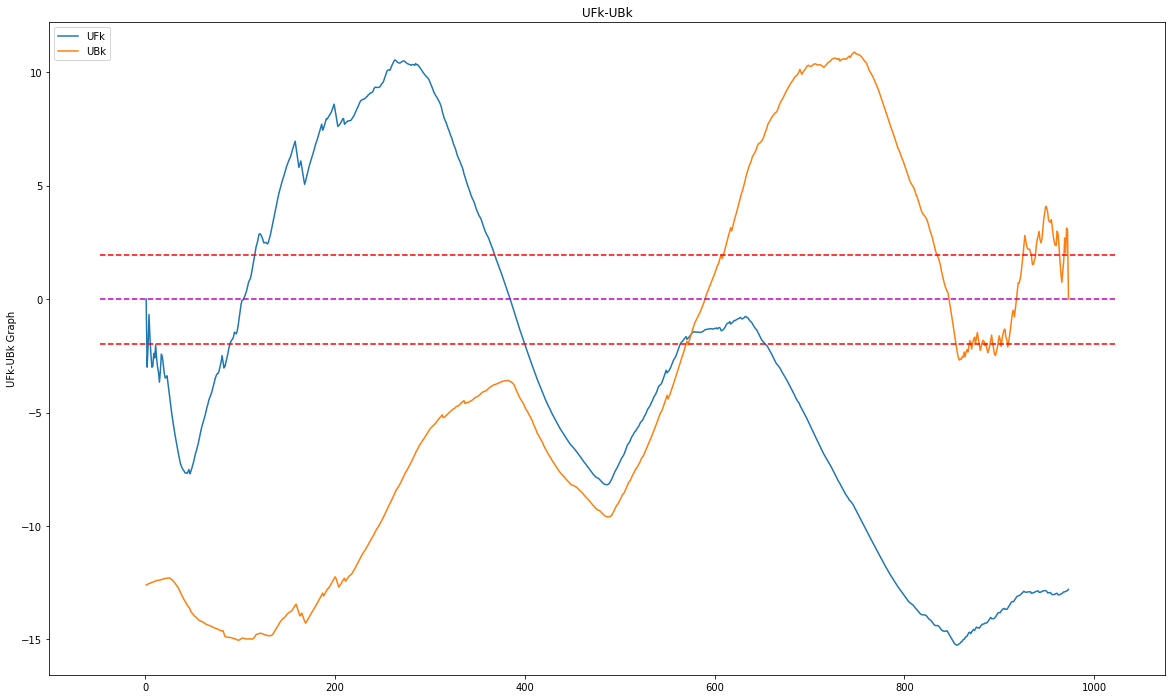

Category 普通工业 max: [359]
Category 普通工业 min: [575]


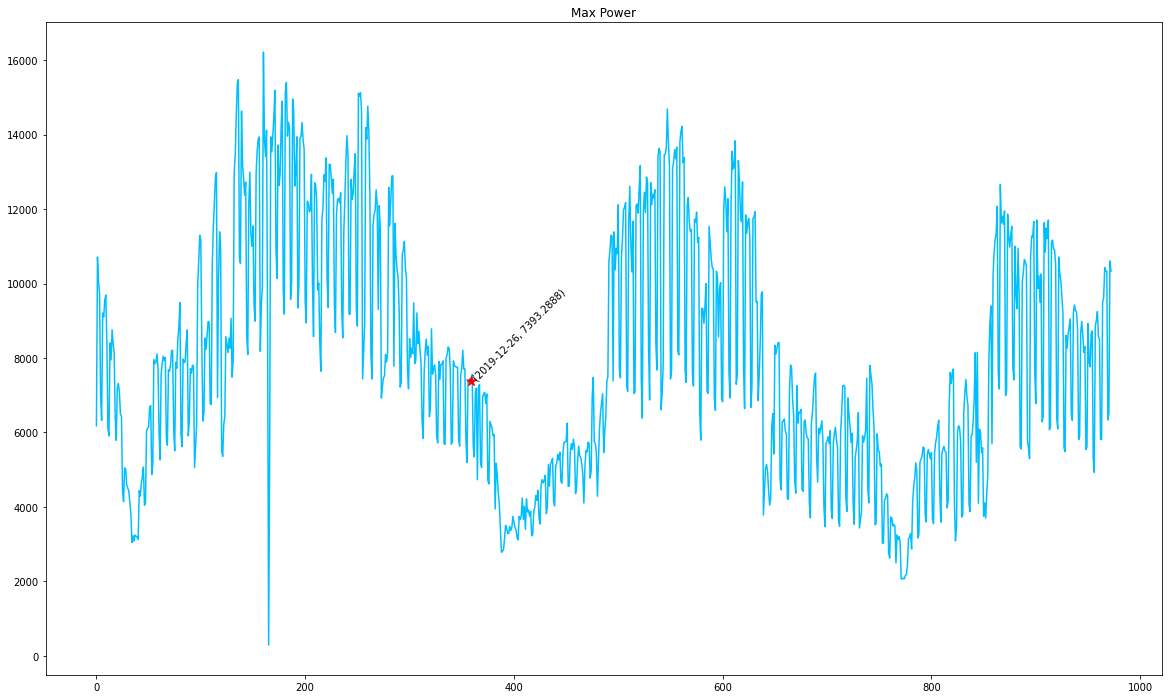

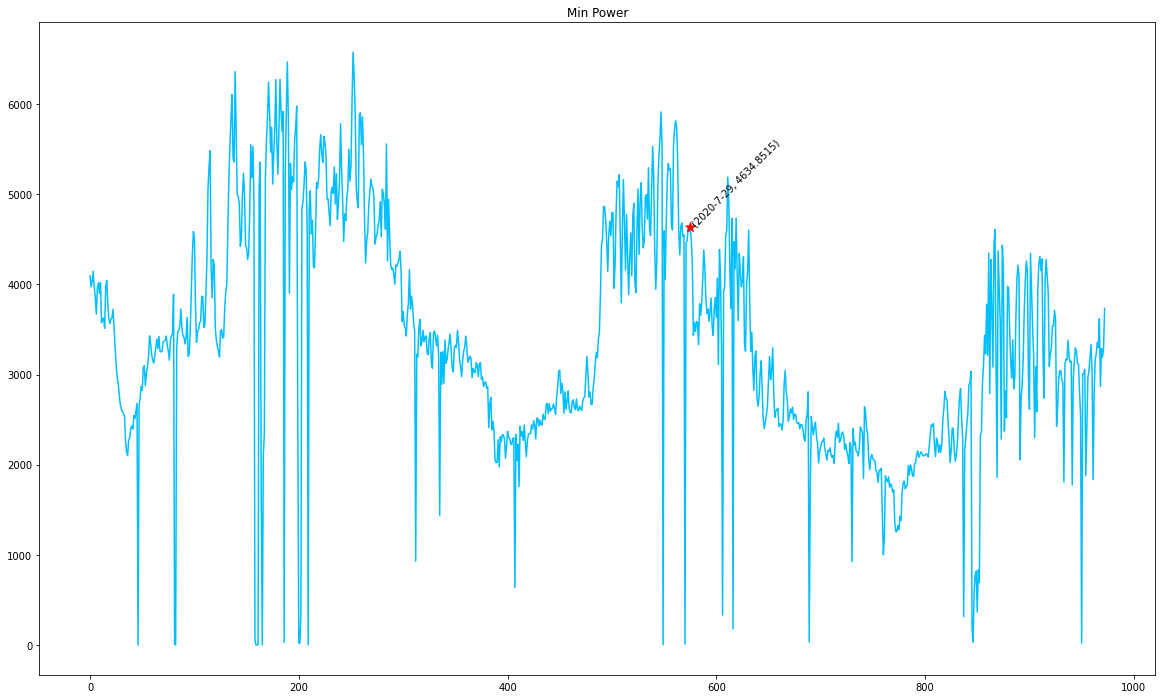

==================非普工业====================


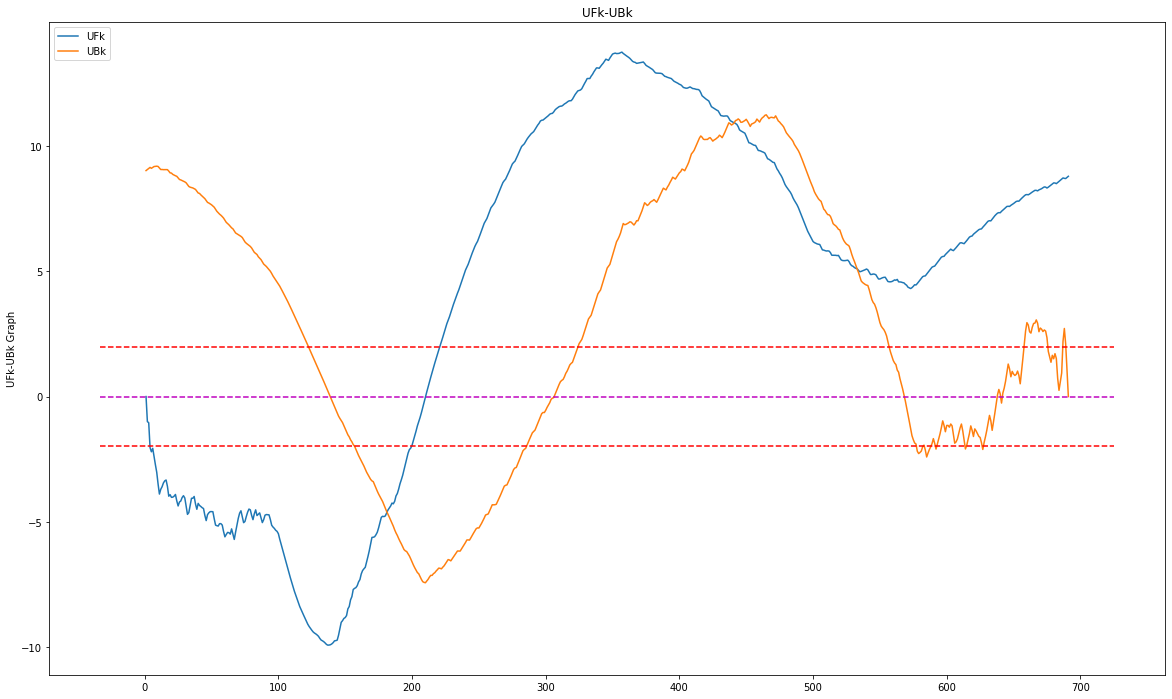

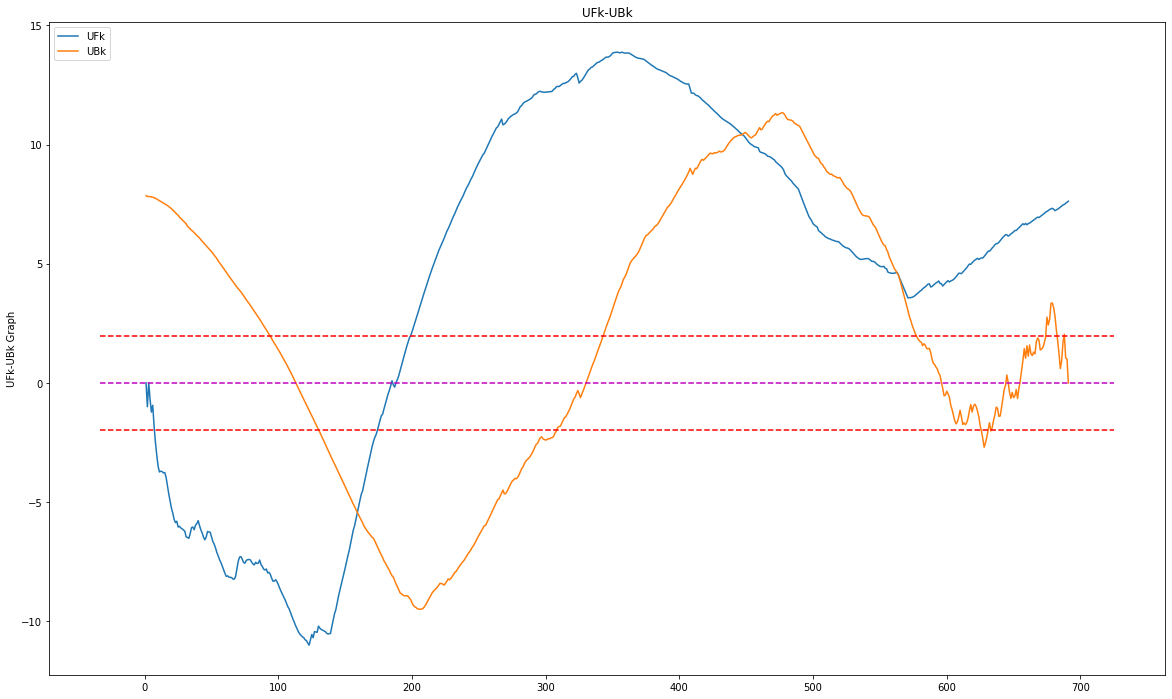

Category 非普工业 max: [181, 441, 532]
Category 非普工业 min: [159, 447, 562, 563, 564]


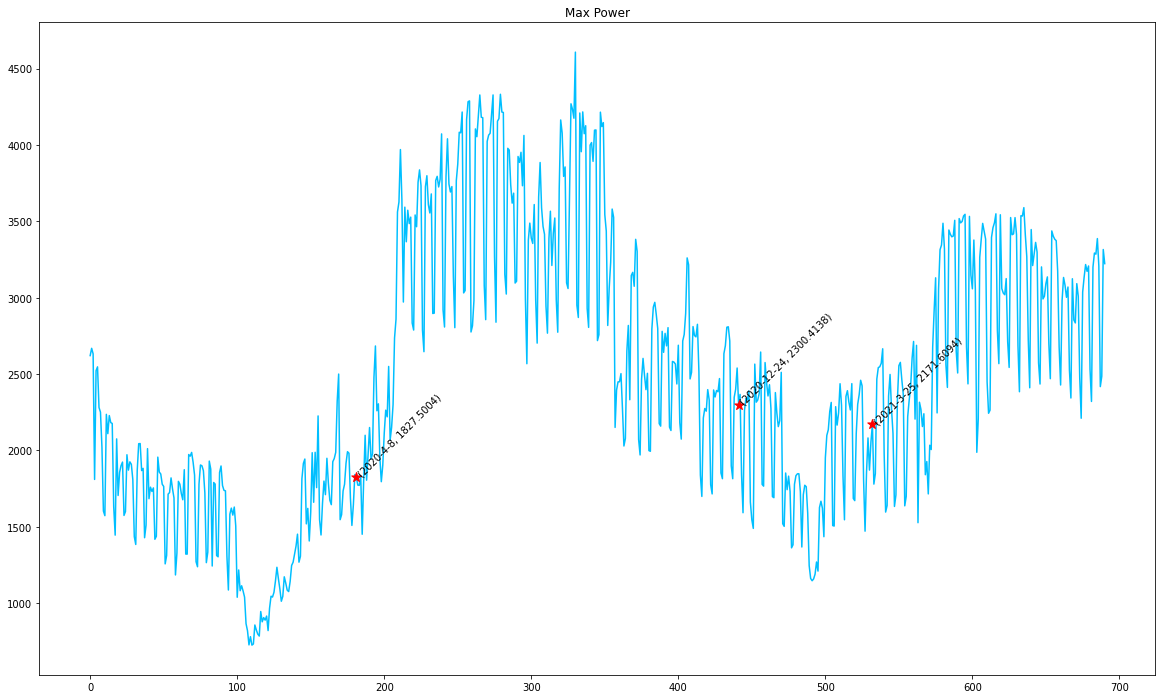

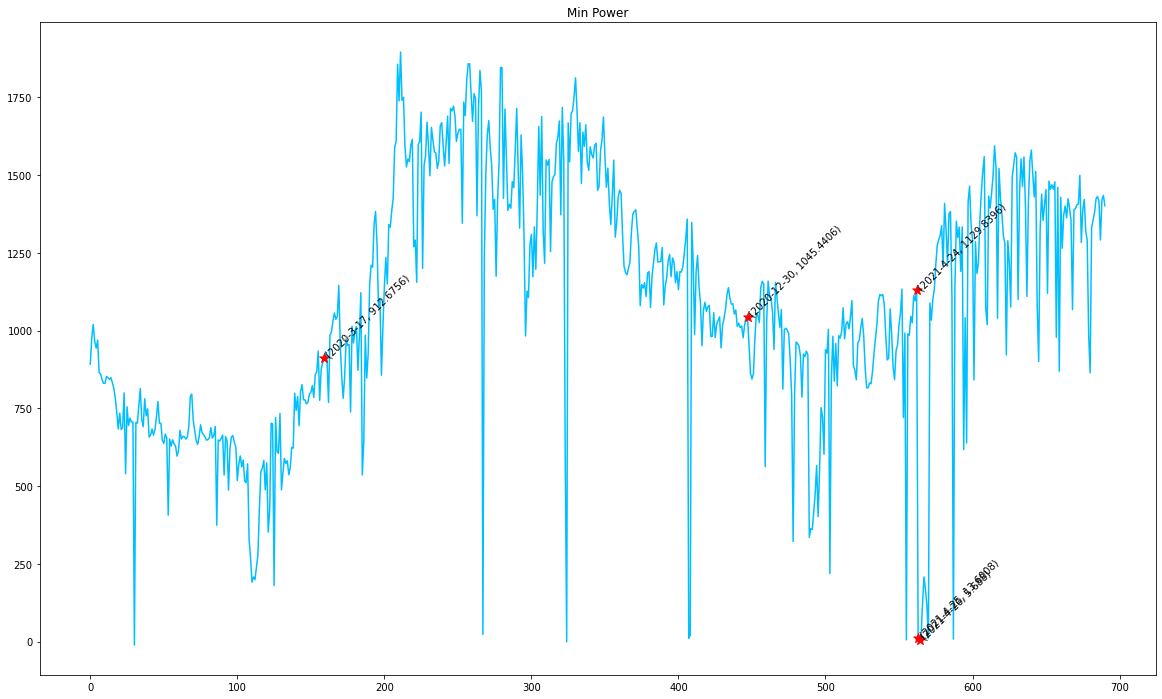

In [89]:
categories = all_data.groupby(['Category'], as_index=False)
for category in categories:
    name, df = category
    print(f'=================={name}====================')
    maxMK, minMK = MK(df['MaxPower']), MK(df['MinPower'])
    print(f'Category {name} max:', maxMK)
    print(f'Category {name} min:', minMK)
    
    min_date = df['Date'].min()
    
    plt.figure(figsize=(20, 12))
    x = np.arange(len(df))
    plt.plot(x, df['MaxPower'], c='deepskyblue')
    y = df.iloc[maxMK]['MaxPower'].to_list()
    plt.scatter(maxMK, y, c='r', marker='*', s=100, zorder=2)
    for i in range(len(y)):
        px = maxMK[i]
        py = y[i]
        cur_date = min_date + pd.Timedelta(f'{px}D')
        yy, m, d = cur_date.year, cur_date.month, cur_date.day
        label = f'({yy}-{m}-{d}, {py})'
        plt.annotate(label, (px, py), rotation=45)
    plt.title('Max Power')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    x = np.arange(len(df))
    plt.plot(x, df['MinPower'], c='deepskyblue')
    y = df.iloc[minMK]['MinPower'].to_list()
    plt.scatter(minMK, y, c='r', marker='*', s=100, zorder=2)
    assert len(y) == len(minMK)
    for i in range(len(y)):
        px = minMK[i]
        py = y[i]
        cur_date = min_date + pd.Timedelta(f'{px}D')
        yy, m, d = cur_date.year, cur_date.month, cur_date.day
        label = f'({yy}-{m}-{d}, {py})'
        plt.annotate(label, (px, py), rotation=45)
    plt.title('Min Power')
    plt.show()

## Q3.2